In [1]:
import shutil
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=2.0)
sns.set_style('whitegrid')

# reduced indel probabilites in this file
from functions2 import *

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False)

with SequenceFile("data/uniprot-9606.fasta", digital=True, alphabet=alphabet) as seq_file:
    sequences = list(seq_file)
    

uniprot = fasta_reader('data/uniprot-9606.fasta')

aa_known = 'ACDEFGHIKLMNPQRSTVWY'



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [22]:
prob_range = [0.9, 0.8, 0.6, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05]



for prob in prob_range:
    temp_df = uniprot.copy()

    temp_df['temp'] = temp_df.values.tolist() 
    temp_df['posteriors'] =  temp_df.temp.parallel_apply(\
                         lambda x: generate_reads(seq=x[1], aa_known=aa_known, max_prob=prob))


    temp_df['temp1'] = temp_df[['Accession', 'posteriors']].values.tolist() 
    temp_df['hmm'] = temp_df.temp1.parallel_apply(\
             lambda x: hmm_build(x[1], x[0], f'full_length_{x[0]}_{aa_known}_max_prob_{prob}'))


    hmms = np.array_split(temp_df.hmm, 10)
    hmms = [i.tolist() for i in hmms]

    results = []
    for i, v in enumerate(hmms):
        results.append(score(v, sequences, background))
    #             print(f'\t\t\t\tdone: {i}', end='\r')
    fname = f'full_length_{aa_known}_max_prob_{prob}_del_reduced_indel_prob.pkl.gz'

    res_df = pd.concat(results)
    res_df.to_pickle('results/scan_results/' + fname)
    del temp_df, res_df, hmms
    shutil.rmtree('temp/', ignore_errors=True)
    try:
        os.makedirs('temp/')
    except FileExistsError:
        pass

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### plotting 

In [2]:
aa_known = 'ACDEFGHIKLMNPQRSTVWY'
prob_range = [0.9, 0.8, 0.6, 0.4, 0.2, 0.3, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05]

all_files = ['results/scan_results/' + f'full_length_{aa_known}_max_prob_{prob}_del_reduced_indel_prob.pkl.gz' \
             for prob in prob_range]
result_dfs = [pd.read_pickle(i) for i in all_files]
# total number of HMMS
hmms = list(range(uniprot.shape[0]))

In [3]:
plot_df = pd.DataFrame(columns=['known aa', 'max_prob', \
                                'total queries', 'hits',  'identified', ])

for i, v in enumerate(result_dfs):
    stats = gen_stats(hmms, v)
    plot_df.loc[i] = [aa_known, prob_range[i], stats['Total queries'],\
                       stats['Hits'], stats['Identified'],]
plot_df['identified_frac'] = plot_df['identified']/plot_df['total queries']
plot_df['Type'] = 'low indel prob.'
plot_df

,known aa,max_prob,total queries,hits,identified,identified_frac,Type
0,ACDEFGHIKLMNPQRSTVWY,0.90,20181,20179,19969,0.989495,low indel prob.
1,ACDEFGHIKLMNPQRSTVWY,0.80,20181,20179,19965,0.989297,low indel prob.
2,ACDEFGHIKLMNPQRSTVWY,0.60,20181,20179,19888,0.985481,low indel prob.
3,ACDEFGHIKLMNPQRSTVWY,0.40,20181,20179,19802,0.98122,low indel prob.
4,ACDEFGHIKLMNPQRSTVWY,0.20,20181,20180,19732,0.977751,low indel prob.
5,ACDEFGHIKLMNPQRSTVWY,0.30,20181,20178,19760,0.979139,low indel prob.
6,ACDEFGHIKLMNPQRSTVWY,0.10,20181,20144,19791,0.980675,low indel prob.
7,ACDEFGHIKLMNPQRSTVWY,0.09,20181,20146,19804,0.981319,low indel prob.
8,ACDEFGHIKLMNPQRSTVWY,0.08,20181,20141,19805,0.981369,low indel prob.
9,ACDEFGHIKLMNPQRSTVWY,0.07,20181,20148,19607,0.971557,low indel prob.


In [4]:
plot_df.to_pickle('results/full_length_all_p_max_reduced_indel_prob.pkl.gz')

In [5]:
plot_df = pd.read_pickle('results/full_length_all_p_max_reduced_indel_prob.pkl.gz')

In [6]:
plot_df1 = pd.read_pickle('results/full_length_all_p_max.pkl.gz')

In [7]:
new_df = pd.concat([plot_df1, plot_df, ])

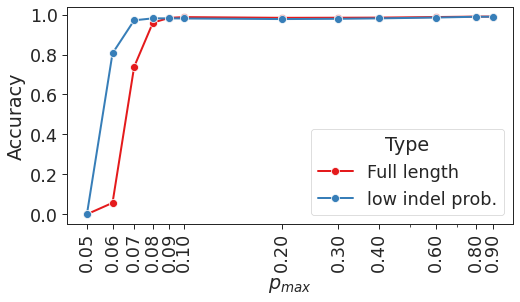

In [10]:
sns.set_context("paper", font_scale=2)
sns.set_style('ticks')
from matplotlib.ticker import ScalarFormatter
plt.figure(figsize=(8, 4))
ax = sns.lineplot(data=new_df, \
                     x='max_prob', y='identified_frac', hue='Type', \
                  palette="Set1", marker='o', markersize=8, lw=2,)
ax.set_xscale('log')
ax.set_xticks(plot_df['max_prob'].value_counts().index, )
ax.tick_params(axis='x', rotation=90)
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.set_xlabel(r'${p_{max}}$')
ax.set_ylabel('Accuracy')
plt.savefig('figs/fig1-logscale-reduced_indels.pdf');